### AWS Tutorial 1

This tutorial will show you how to grid 1 month of the blended TROPOMI+GOSAT atmospheric methane satellite data product to a 1° x 1° grid. The data for January 2022 is used.

Nicholas Balasus\
8 February 2024

In [1]:
import s3fs
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from joblib import Parallel, delayed

ERROR 1: PROJ: proj_create_from_database: Open of /n/home06/nbalasus/micromamba/envs/blnd_env/share/proj failed


The data are organized into one netCDF file per orbit. TROPOMI makes about 14 orbits per day. There are many variables available in each file as described in the [documentation](https://github.com/nicholasbalasus/write_blended_files/blob/main/PUM.md). Here, we will use the location of each retrieval (latitude, longitude) and the methane column (methane_mixing_ratio_blended). We write a function to extract this data one file at a time (while also filtering out coastal pixels).

In [2]:
# Function that extracts latitude, longitude, and XCH4 from each file
def process_one_file(file):

    file_ob = fs.open(file)

    with xr.open_dataset(file_ob) as ds:

        # Filter out coastal pixels following Balasus et al. (2023)
        sc = (ds["surface_classification"].values[:].astype("uint8") & 0x03).astype(int)
        valid_idx = ~((sc == 3) | ((sc == 2) & (ds["chi_square_SWIR"].values > 20000)))

        # Make a DataFrame for this file
        df = pd.DataFrame({"lat": ds["latitude"].values[valid_idx],
                           "lon": ds["longitude"].values[valid_idx],
                           "xch4": ds["methane_mixing_ratio_blended"].values[valid_idx]})

    return df

We'll use multiple cores to process all of the files.

In [3]:
# Connect to S3 and get a list of all of the file paths for January 2022
fs = s3fs.S3FileSystem(anon=True)
files = fs.glob("s3://blended-tropomi-gosat-methane/data/2022-01/*.nc")

# Use multiple cores to collect dataframes; then, concatenate them together
results = Parallel(n_jobs=-1)(delayed(process_one_file)(file) for file in files)
df = pd.concat(results, ignore_index=True)
df.info()
df.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17170956 entries, 0 to 17170955
Data columns (total 3 columns):
 #   Column  Dtype  
---  ------  -----  
 0   lat     float32
 1   lon     float32
 2   xch4    float32
dtypes: float32(3)
memory usage: 196.5 MB


,lat,lon,xch4
0,-85.973503,-65.540215,1666.525391
1,-85.882942,-66.196953,1670.043213
2,-85.199837,-70.823868,1679.275635


We'll now use simple rounding of the latitude and longitude to regrid to a 1° x 1° grid.

In [4]:
df_rounded = pd.DataFrame({"xch4": df["xch4"],
                           "lon": np.round(df["lon"], 0),
                           "lat": np.round(df["lat"], 0)})
                           
ds_mean = df_rounded.groupby(["lat","lon"]).mean().to_xarray()
ds_count = df_rounded.groupby(["lat","lon"]).count().to_xarray()

Now, the average XCH4 and the observational density can be plotted.

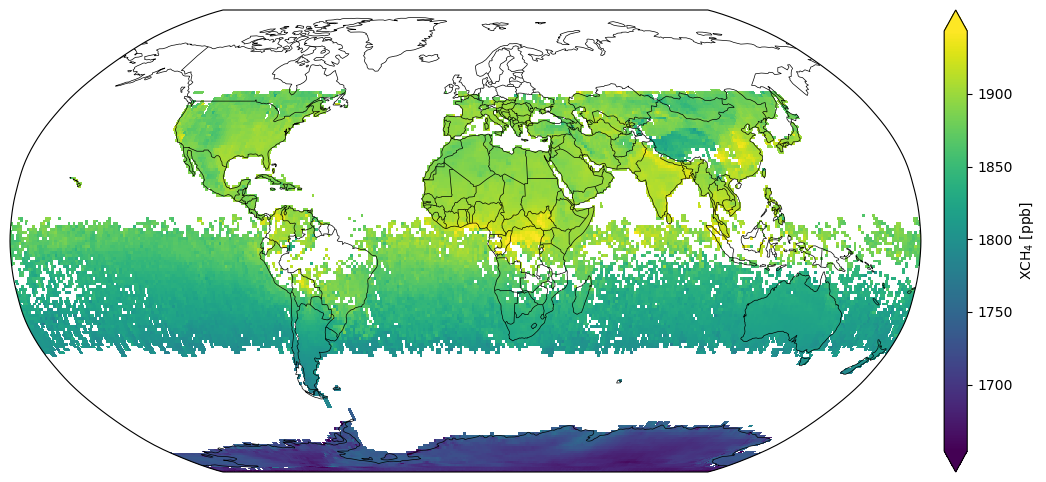

In [5]:
fig,ax = plt.subplots(figsize=(15,6), subplot_kw={"projection": ccrs.Robinson()})
vmin = np.nanpercentile(ds_mean["xch4"], 0.1)
vmax = np.nanpercentile(ds_mean["xch4"], 99.9)
ds_mean["xch4"].plot(ax=ax, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree(),
                     cbar_kwargs={"label":"XCH$_4$ [ppb]", "pad": 0.02})
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.coastlines(linewidth=0.5)
ax.set_global()

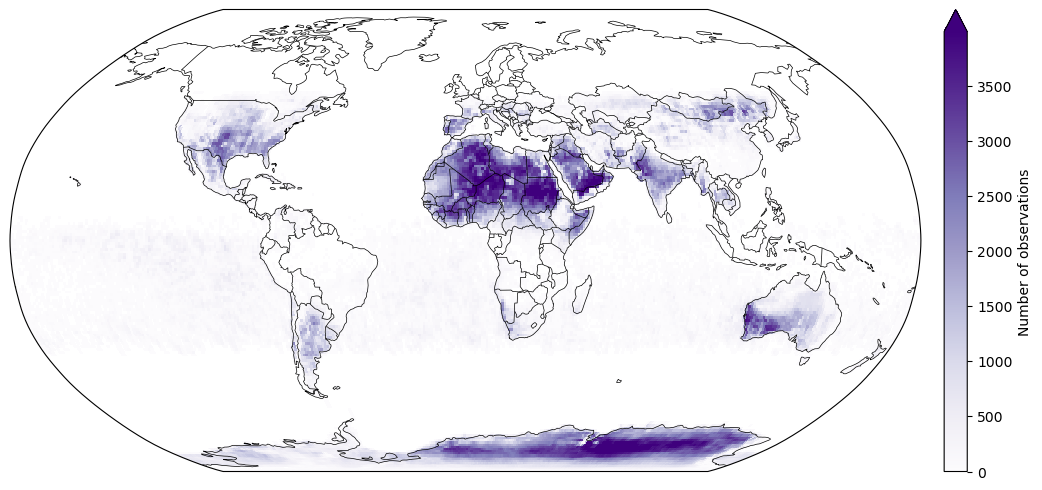

In [6]:
fig,ax = plt.subplots(figsize=(15,6), subplot_kw={"projection": ccrs.Robinson()})
vmax = np.nanpercentile(ds_count["xch4"], 99)
ds_count["xch4"].plot(ax=ax, vmin=0, vmax=vmax, cmap="Purples", transform=ccrs.PlateCarree(),
                      cbar_kwargs={"label":"Number of observations", "pad": 0.02})
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.coastlines(linewidth=0.5)
ax.set_global()